# Equable triangles on grids

This notebook was used to find all equable triangles on a 2-dimensional grid. For more information about the theory used in this notebook, you can look at my [paper](https://eur03.safelinks.protection.outlook.com/?url=http%3A%2F%2Fresolver.tudelft.nl%2Fuuid%3Aec228956-de2a-4d2d-bac2-060ac9a6395e&data=05%7C02%7CL.deHoop%40student.tudelft.nl%7C687a469b0f174713f9d108dc9b606aaa%7C096e524d692940308cd38ab42de0887b%7C0%7C0%7C638556085601838698%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C0%7C%7C%7C&sdata=bVEOKn8bl%2FB0dFYJ17gNda5BvvqufKw%2FfZP8enoG2Ow%3D&reserved=0). We have limited ourselves to grids generated with unit length vectors that have an angle $\theta \in (0,\pi/2]$ such that $\cos(\theta)$ is rational. For other angles, we can always find an equivalent lattice as specified in Example 2.14.

## Imports and Functions

In [ ]:
import numpy as np
import math
import sympy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

In [ ]:
def SideLength(p,q):
    """
    Find all equable triangles of the form rn with n integral.
    Args:
        - p: the numerator of cos(theta).
        - q: the denominator of cos(theta).
    Returns:
        - r: a sympy value, each equable triangle on this grid must have side lengths of the form rn with n integral.
    """
    # reduce p and q such that they are co-prime
    g = math.gcd(p,q)
    p,q = p // g, q // g

    # apply Theorem 3.6
    u,v = 1, q**2 - p**2
    d = 2
    while d**2 <= v:
        if v % d**2 == 0:
            u,v = u*d, v // d**2
        else:
            d+=1
    r = sympy.sqrt(v) / (q)

    # apply Corollary 3.4 if possible
    if q % 2 == 0:
        r *= 2
    return r

In [ ]:
def FindCandidates(r):
    """
    Finds all equable triangles of the form rn with n integral.
    Args:
        - r: a sympy value, each side length is of the form rn with n integral.

    Returns:
        - candidates: a list of tuples, each tuple contains the 3 side lengths of the triangle as a sympy value.
    """

    # r^2 must be rational
    if not (r**2).is_rational:
        return []

    p = (r**2).numerator
    candidates = []
    if p % 16 != 0 :
        # Use upper bounds from theorem A.1
        u_upper = 2 / r * sympy.sqrt(3)
        u = 1
        while u <= u_upper:
            v = u
            v_upper = (4 + 2 * sympy.sqrt(4 + r**2*u**2)) / (r**2*u)
            while v <= v_upper:
                if r**2 * u * v - 4 > 0:
                    w = 4*(u+v) / (r**2 * u * v - 4)
                    if v <= w:
                        if w.is_integer:
                            a,b,c = r*(v+w), r*(u+w), r*(u+v)
                            candidates.append((a,b,c))
                v+=1
            u+=1

    else:
        # Use upper bounds from theorem 3.12
        x_upper = 4 / r * sympy.sqrt(3)
        x = 1
        while x <= x_upper:
            y = x
            y_upper = (16 + 4 * sympy.sqrt(16 + r**2*x**2)) / (r**2*x)
            while y <= y_upper:
                if r**2 * x * y - 16 > 0:
                    z = 16*(x+y) / (r**2 * x * y - 16)
                    if y <= z:
                        if z.is_integer:
                            # check if the same parity
                            if x % 2 == y % 2 == z % 2:
                                a,b,c = r/2*(y+z), r/2*(x+z), r/2*(x+y)
                                candidates.append((a,b,c))
                y+=1
            x+=1

    return candidates

In [ ]:
def IsPlaceable(triangle, cos_theta):
    """
    Checks if a triangle is placeable on a grid generated by 1 and cos(theta) + sin(theta)*i.
    Args:
        - triangle: a tuple with 3 sympy values, these are the side lengths of the triangle we want to check.
        - cos_theta: a sympy value for cos(theta).

    Returns:
        - placeable: boolean whether the triangle is placeable on the grid.
    """
    # define sin_theta
    sin_theta = sympy.sqrt(1 - cos_theta**2)
    # sorts the side lengths to reduce search space.
    triangle = sorted(triangle)

    # finds all possible values for a1 and a2 to get the 1st length using Theorem 4.4
    first_coord_options = []
    a = triangle[0]
    n = sympy.floor(a / sin_theta)
    for a1 in range(sympy.floor(n)+1): # can ignore negative part because of 180 degree rotational symmetry
        a2_plus = -a1*cos_theta + sympy.sqrt(a**2 - sin_theta**2 * a1**2)
        if a2_plus.is_integer:
            first_coord_options.append((a1,a2_plus))
        a2_min = -a1*cos_theta - sympy.sqrt(a**2 - sin_theta**2 * a1**2)
        if a2_min.is_integer:
            first_coord_options.append((a1,a2_min))

    # If side length a cannot be placed, triangle cannot be placed
    if len(first_coord_options) == 0:
        return False

    # finds all possible values for b1 and b2 to get the 2nd length Theorem 4.4
    second_coord_options = []
    b = triangle[1]
    n = sympy.floor(b / sin_theta)
    for b1 in range(-sympy.floor(n),sympy.floor(n)+1):
        b2_plus = -b1*cos_theta + sympy.sqrt(b**2 - sin_theta**2 * b1**2)
        if b2_plus.is_integer:
            second_coord_options.append((b1,b2_plus))
        b2_min = -b1*cos_theta - sympy.sqrt(b**2 - sin_theta**2 * b1**2)
        if b2_min.is_integer:
            second_coord_options.append((b1,b2_min))

    # If side length b cannot be placed, triangle cannot be placed
    if len(second_coord_options) == 0:
        return False

    # try different combinations of (a1,a2) and (b1,b2) to see if they make the 3rd side length
    c = triangle[2]
    for (a1,a2) in first_coord_options:
        for (b1,b2) in second_coord_options:
            c_squared = (a1-b1)**2 + 2 * (a1-b1) * (a2-b2) * cos_theta + (a2-b2)**2
            if c_squared == c**2:
                return True

    return False

In [ ]:
def TryGrid(p,q):
    """
    Find all equable triangles in 3 steps:  1. Find constraint on side lengths.
                                            2. Find equable triangles with that constraint.
                                            3. Try to place triangles on the grid.
    Grid is generated with 1 and cos(theta) + sin(theta)*i, with cos(theta)=p/q rational.

    Args:
        - p: numerator of cos(theta)
        - q: denominator of cos(theta)

    Returns:
        - r: a sympy value, each side length is of the form rn with n integral.
        - placeable_triangles: a list of tuples containing the side lengths of equable triangles placeable on the grid.
        - candidates: a list of tuples containing the side lengths of candidate equable triangles.
    """
    # find r
    r = SideLength(p,q)

    # find possible candidates
    candidates = FindCandidates(r)

    # try to place triangles on grid
    placeable_triangles = []
    for triangle in candidates:
        if IsPlaceable(triangle, sympy.Rational(p,q)):
            placeable_triangles.append(triangle)

    return r, placeable_triangles, candidates

## Introduction


In [ ]:
# Change this depending on where the pickled file is located
GRID_DICTIONARY_LOCATION = "drive/MyDrive/Colab Notebooks/Grid_dictionary.pkl"

# load data
with open(GRID_DICTIONARY_LOCATION, 'rb') as f:
    grid_dict = pickle.load(f)
print("Succesfully loaded the data.")
print(f"The dictionary consists of {len(grid_dict.keys())} entries.")

Succesfully loaded the data.
The dictionary consists of 3044 entries.


In [ ]:
## Check what equable triangles are possible on a certain grid with cos(theta) = p/q

# Select p and q you want to see. Only valid for co-prime p,q in {1,...,100} with p<q
p,q = 2,3
g = math.gcd(p,q)
p,q = p//g, q//g

if (p,q) not in grid_dict.keys():
    print(f"{p,q} is not in the dictionary.")
else:
    r, placeable_triangles, candidates = grid_dict[(p,q)]
    print(f"For cos(theta) = {p}/{q}, all equable triangles are of the form rn with n a natural number and r = {r}.")
    print(f"There are {len(candidates)} equable triangles that satisfy this criteria.")
    print(f"Out of these candidates, {len(placeable_triangles)} could be placed on the grid.")
    if len(placeable_triangles) > 0:
        print("These are the placeable triangles:")
        for triangle in placeable_triangles:
            print(triangle)

For cos(theta) = 2/3, all equable triangles are of the form rn with n a natural number and r = sqrt(5)/3.
There are 7 equable triangles that satisfy this criteria.
Out of these candidates, 2 could be placed on the grid.
These are the placeable triangles:
(9*sqrt(5), 9*sqrt(5), 2*sqrt(5))
(4*sqrt(5), 3*sqrt(5), 3*sqrt(5))


## Tests for Integer and Eisenstein lattice

In [ ]:
# Integer test
p,q = 0,1
cos_theta = sympy.Rational(p,q)

# Find r
r = SideLength(p,q)
print(f"For the integer lattice, all equable triangles are of the form rn with n a natural number and r = {r}.")

candidates = FindCandidates(r)
print(f"There are {len(candidates)} equable triangles that satisfy this criteria.")

placeable_triangles = []
for triangle in candidates:
    if IsPlaceable(triangle,cos_theta):
        placeable_triangles.append(triangle)
print(f"Out of these candidates, {len(placeable_triangles)} could be placed on the grid.")
if len(placeable_triangles) > 0:
    print("These are the placeable triangles:")
    for triangle in placeable_triangles:
        print(triangle)
r = SideLength(p,q)

For the integer lattice, all equable triangles are of the form rn with n a natural number and r = 1.
There are 5 equable triangles that satisfy this criteria.
Out of these candidates, 5 could be placed on the grid.
These are the placeable triangles:
(29, 25, 6)
(20, 15, 7)
(17, 10, 9)
(13, 12, 5)
(10, 8, 6)


In [ ]:
# Eisenstein test
p,q = 1,2
cos_theta = sympy.Rational(p,q)

# Find r
r = SideLength(p,q)
print(f"For the Eisenstein lattice, all equable triangles are of the form rn with n a natural number and r = {r}.")

candidates = FindCandidates(r)
print(f"There are {len(candidates)} equable triangles that satisfy this criteria.")

placeable_triangles = []
for triangle in candidates:
    if IsPlaceable(triangle,cos_theta):
        placeable_triangles.append(triangle)
print(f"Out of these candidates, {len(placeable_triangles)} could be placed on the grid.")
if len(placeable_triangles) > 0:
    print("These are the placeable triangles:")
    for triangle in placeable_triangles:
        print(triangle)
r = SideLength(p,q)

For the integer lattice, all equable triangles are of the form rn with n a natural number and r = sqrt(3).
There are 2 equable triangles that satisfy this criteria.
Out of these candidates, 2 could be placed on the grid.
These are the placeable triangles:
(8*sqrt(3), 7*sqrt(3), 3*sqrt(3))
(4*sqrt(3), 4*sqrt(3), 4*sqrt(3))


## Checking for new grids

In [ ]:
# Find the equable triangles for new values of (p,q)

for q in tqdm(range(2,101)):
    for p in range(q): # 0 <= p < q
        # p and q must be co-prime
        if math.gcd(p,q) == 1:
            if (p,q) not in grid_dict.keys():
                # Find equable triangles and add to dictionary
                r, placeable_triangles, candidates = TryGrid(p,q)
                grid_dict[(p,q)] = r, placeable_triangles, candidates

                # Save if just finished a large batch in case of timeout error
                if len(candidates) > 100:
                    with open(GRID_DICTIONARY_LOCATION, 'wb') as f:
                        pickle.dump(grid_dict, f)
                    print(f"Saved for {(p,q)} with {len(candidates)} triangles")

# Save data
with open(GRID_DICTIONARY_LOCATION, 'wb') as f:
    pickle.dump(grid_dict, f)

  0%|          | 0/99 [00:00<?, ?it/s]

# Observations


In [ ]:
# Print all found equable triangles
for (p,q) in grid_dict.keys():
    r, placeable_triangles, candidates = grid_dict[(p,q)]
    if len(placeable_triangles) > 0:
        print(f"Grid with cos(theta) = {p}/{q}")
        print(f"r = {r}")
        print(f"Has {len(candidates)} candidates")
        print(f"All {len(placeable_triangles)} actually placeable triangles:")
        for t in placeable_triangles:
            print(t)
        print()

Grid with cos(theta) = 0/1
r = 1
Has 5 candidates
All 5 actually placeable triangles:
(29, 25, 6)
(20, 15, 7)
(17, 10, 9)
(13, 12, 5)
(10, 8, 6)

Grid with cos(theta) = 1/2
r = sqrt(3)
Has 2 candidates
All 2 actually placeable triangles:
(8*sqrt(3), 7*sqrt(3), 3*sqrt(3))
(4*sqrt(3), 4*sqrt(3), 4*sqrt(3))

Grid with cos(theta) = 1/3
r = sqrt(2)/3
Has 17 candidates
All 1 actually placeable triangles:
(6*sqrt(2), 6*sqrt(2), 4*sqrt(2))

Grid with cos(theta) = 2/3
r = sqrt(5)/3
Has 7 candidates
All 2 actually placeable triangles:
(9*sqrt(5), 9*sqrt(5), 2*sqrt(5))
(4*sqrt(5), 3*sqrt(5), 3*sqrt(5))

Grid with cos(theta) = 3/5
r = 1/5
Has 52 candidates
All 5 actually placeable triangles:
(29, 25, 6)
(20, 15, 7)
(17, 10, 9)
(13, 12, 5)
(10, 8, 6)

Grid with cos(theta) = 4/5
r = 1/5
Has 52 candidates
All 5 actually placeable triangles:
(29, 25, 6)
(20, 15, 7)
(17, 10, 9)
(13, 12, 5)
(10, 8, 6)

Grid with cos(theta) = 1/9
r = sqrt(5)/9
Has 27 candidates
All 1 actually placeable triangles:
(58*sqr

## Integer sided equable triangles

For the equable triangles with integer side length to be placeable on a grid, we found that the pair $(p,q)$ such that $\cos(\theta)=\frac{p}{q}$ must be part of a Pythagorean triple. With this, we can more efficiently look for grids on which the equable triangles can be placed.

In [ ]:
# Generate a list of Pythagorean pairs such that the largest value(hypotenuse) is < 1000
max_value = 1000

mn_bounds = math.ceil(math.sqrt(max_value))
pythagorean_pairs = []
for n in range(1,mn_bounds):
    for m in range(n+1,mn_bounds):
        if math.gcd(n,m) == 1:
            if n % 2 != m % 2:
                x,y,z = m**2-n**2, 2*m*n, m**2+n**2
                if z <= max_value:
                    pythagorean_pairs.append((x,z))
                    pythagorean_pairs.append((y,z))

pythagorean_pairs.sort(key=lambda a: a[1])
print(pythagorean_pairs)

[(3, 5), (4, 5), (5, 13), (12, 13), (15, 17), (8, 17), (7, 25), (24, 25), (21, 29), (20, 29), (35, 37), (12, 37), (9, 41), (40, 41), (45, 53), (28, 53), (11, 61), (60, 61), (63, 65), (16, 65), (33, 65), (56, 65), (55, 73), (48, 73), (77, 85), (36, 85), (13, 85), (84, 85), (39, 89), (80, 89), (65, 97), (72, 97), (99, 101), (20, 101), (91, 109), (60, 109), (15, 113), (112, 113), (117, 125), (44, 125), (105, 137), (88, 137), (143, 145), (24, 145), (17, 145), (144, 145), (51, 149), (140, 149), (85, 157), (132, 157), (119, 169), (120, 169), (165, 173), (52, 173), (19, 181), (180, 181), (153, 185), (104, 185), (57, 185), (176, 185), (95, 193), (168, 193), (195, 197), (28, 197), (187, 205), (84, 205), (133, 205), (156, 205), (171, 221), (140, 221), (21, 221), (220, 221), (221, 229), (60, 229), (105, 233), (208, 233), (209, 241), (120, 241), (255, 257), (32, 257), (247, 265), (96, 265), (23, 265), (264, 265), (69, 269), (260, 269), (115, 277), (252, 277), (231, 281), (160, 281), (161, 289), (2

In [ ]:
# Check for each integer equable triangle if they can be placed on a grid formed by a Pythagorean pair.
integer_triangles = [(10, 8, 6), (13, 12, 5), (17, 10, 9), (20, 15, 7), (29, 25, 6)]

for triangle in integer_triangles:
    print(f"Triangle {triangle} can be placed on the grids:")
    for (p,q) in pythagorean_pairs:
        if IsPlaceable(triangle,sympy.Rational(p,q)):
            print(f"{p}/{q}")
    print()

Triangle (10, 8, 6) can be placed on the grids:
3/5
4/5
15/17
7/25
143/145

Triangle (13, 12, 5) can be placed on the grids:
3/5
4/5
5/13
12/13
35/37

Triangle (17, 10, 9) can be placed on the grids:
3/5
4/5
15/17
77/85
323/325

Triangle (20, 15, 7) can be placed on the grids:
3/5
4/5
5/13
24/25
35/37
220/221

Triangle (29, 25, 6) can be placed on the grids:
3/5
4/5
12/13
7/25
21/29
99/101
143/145



## Constraints on side lengths

This code was used to create Figures 5.1 and 5.2

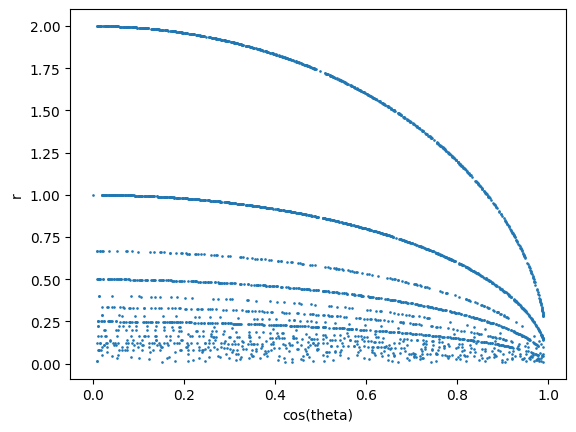

In [ ]:
# Figure 5.1
r_values = []
cos_values = []
for (p,q) in grid_dict.keys():
    r, placeable_triangles, candidates = grid_dict[(p,q)]
    # if q % 2 == 0:
    #     r /= 2
    r_values.append(r)
    cos_values.append(p / q)
plt.scatter(cos_values,r_values,s=0.8)

plt.xlabel("cos(theta)")
plt.ylabel("r")
plt.show()

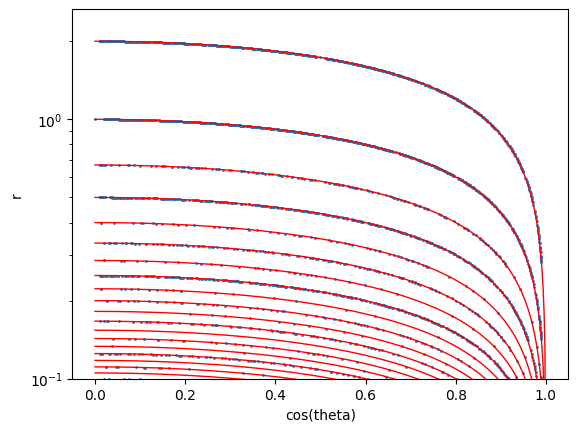

In [ ]:
# Figure 5.2

# Plot first few lines
X = np.linspace(0,1,500)
for u in range(1,20):
    Y = [2*np.sqrt(1-x**2)/u for x in X]
    plt.plot(X,Y, color='red', linestyle='-',linewidth=1)

plt.scatter(cos_values,r_values,s=1)
plt.xlabel('cos(theta)')
plt.ylabel('r')
plt.yscale("log")
plt.ylim(0.1,None)
plt.show()